**Project Task C)**
<br> **Authors:** 
<br>Clara Hardes, Elisa Hagensieker

<br> **Our motivation:**
<br> Let us first explain the research project on which our project is based. It is not only about getting yes-no answers from lucid dreaming, but also about measuring eye movements and reconstructing them using electrooculography. 
Imagine a shape or a word and draw it with your finger while tracing your finger with your eyes. Electrooculography measures their eye movements during sleep so that the movements can be reconstructed. This can be done with either objects or words. 
<br> With this approach it is possible to interact with the waking world. The applications are very diverse: the classified words can be used to send messages during lucid dreaming, to set a timer to wake up in 10 minutes, or to write down important ideas you had during dreaming; classified images can be used for a more creative field: to draw pictures, to learn, or to capture ideas during sleep. 

<br> **Project explanation:**
<br> Since this information should preferably be processed in real time and not be processed by humans, as this would take a lot of time, we have built a neural network that classifies these images. 
<br> To do this, we use an existing dataset that shows images drawn by humans. This dataset should therefore resemble images drawn by imagination. It can easily be replaced with other data such as words given as images. then preprocess the data before it is fed into the convolutional neural network. The network takes an image and extracts different features in each layer. At the end it outputs its prediction as a label. 


<br> In the following snippet we load our dataset and print ds_info to get an overview:

In [ ]:
"""
@authors: chardes, ehagensieker
"""
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import tqdm
import pprint

ds,ds_info = tfds.load('quickdraw_bitmap', split='train', as_supervised=True,with_info=True)
ds_info



c:\Users\clara\anaconda3\envs\iannwtf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tfds.core.DatasetInfo(
    name='quickdraw_bitmap',
    version=1.0.0,
    description='The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The bitmap dataset contains these drawings converted from vector format into 28x28 grayscale images',
    urls=['https://github.com/googlecreativelab/quickdraw-dataset'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=345),
    }),
    total_num_examples=50426266,
    splits={
        'train': 50426266,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/HaE17,
      author    = {David Ha and
                   Douglas Eck},
      title     = {A Neural Representation of Sketch Drawings},
      journal   = {CoRR},
      volume    = {abs/1704.03477},
      year      = {2017},
      url       = {http://arxiv.org/abs/1704.03477},

Now we have to filter our dataset, so that we have only 4 classes to predict, and to split it into train data and test data:

In [ ]:
def split_data(ds):
  '''
    filter and split data
    Args: 
        data: 
            Dataset that we use for the task 
    '''
  ds = ds.filter(lambda _,target: target>=1 and target<= 4)
  len_ds = 572762 
  test_ds_size = int(len_ds * 0.2) # 20 percent of length of ds
  train_ds = ds.skip(test_ds_size)
  test_ds = ds.take(test_ds_size)
  return train_ds,test_ds

Let us have a look at some of the images, that we would like to predict with our model: 

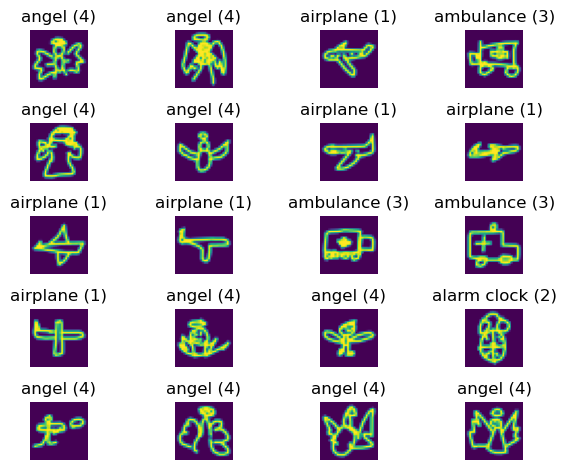

In [ ]:
train_ds,test_ds = split_data(ds)

#labels for the different images we would like to classify
label_names = {}
label_names[1]='airplane'
label_names[2]= 'alarm clock'
label_names[3] = 'ambulance'
label_names[4] = 'angel'

pictures = []
labels = []

#we would like to visualize 20 examples 
for e in test_ds.take(20):
    pictures.append(e[0])
    labels.append(e[1])

fig,axes = plt.subplots(nrows=5,ncols=4)
i=0

#visualization 
for row in range(5):
    for col in range(4):
        axes[row][col].imshow(pictures[i])
        axes[row][col].set_title(label_names[int(labels[i])] + " (" + str(int(labels[i])) + ")")
        axes[row][col].axis('off')
        i=i+1
fig.tight_layout()

Next we have to preprocess our data to have the correct shape, datatype and target vector. We cache, shuffle, batch and prefetch our data to make sure that we are training on different classes, that we already have data stored in our memory and train on batches of images. 

In [ ]:
def prepare(data,batch_size):
    '''
    prepare the dataset to have one-hot-vectors for all four targets (multiclass problem)
    Args: 
        batch_size(int): 
            Size of the batch, that we use for each epoch
        data: 
            Dataset that we use for the task and that we have to preprocess
    '''
    data = data.map(lambda x, t: ((tf.cast(x, tf.float32)/128.)-1.,tf.cast(t, dtype=tf.dtypes.int32)))
    data = data.map(lambda img, target: (img, tf.one_hot(target-1, depth=4)))
    data = data.cache().shuffle(1028).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return data

Now we come to the most interesting part: the model! We create a convolutional network which is mainly used to process images. It takes the image as a whole and with each convolutional layer we get different information from the image. 

In [ ]:
from tensorflow.keras.layers import Dense

class BasicConv(tf.keras.Model):
  '''
  create a small network with 2 blocks each having 2 layers and starting with 32 filters in the first layer
  '''
  def __init__(self, optimizer = tf.keras.optimizers.Adam()):
    super(BasicConv, self).__init__()

    #usally we take ADAM as optimizer, because it performs best
    self.optimizer = optimizer
    #as there are many classes to predict we use the categorical crossentropy
    self.loss_function = tf.keras.losses.CategoricalCrossentropy()
    

    self.metrics_list = [tf.keras.metrics.Mean(name = "loss"),
                         tf.keras.metrics.CategoricalAccuracy(name = "acc")]

    #we use 2 blocks of conv2D layers, the first with 32 filters and the second with 64 filters, between them we do some pooling to reduce the size of each feature map, as the ouput layer we take a dense layer with 4 units (4 classes)
    self.layer_list =  [tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
                        tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'),
                        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
                        tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
                        tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
                        tf.keras.layers.GlobalAvgPool2D(),
                        tf.keras.layers.Dense(4, activation = 'softmax')]
                        
    
  def call(self, x , training = False):
    '''
    call the model and therefore all its layers
    Args: 
        x(tensor): 
            input (images)
        training(boolean): 
            should the model train or not
    '''
    for layer in self.layer_list:
      x = layer(x)
    return x


  @property
  def metrics(self):
    '''
    get the metrics of the model (loss and accuracy)
    '''
    return self.metrics_list


  def reset_metrics(self):
    '''
    reset the metrics of the model 
    '''
    for metric in self.metrics: 
      metric.reset_states()

  
  @tf.function 
  def train_step(self, data):
    '''
    specifying the training of the model, using tf.GradientTape to backpropagate the gradient through the model, updating the metrics
    Args: 
        data(tensor): 
            train data, image and target
    '''
    x, t = data
  

    with tf.GradientTape() as tape:
      output = self(x, training = True)
      loss = self.loss_function(t, output)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.metrics[0].update_state(loss)
   
    
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

  @tf.function
  def test_step(self, data):
    '''
    getting the loss of the test data and updating the metrics
    Args: 
        data(tensor): 
            a batch of test data, image and target
    '''
    x, t = data

    output = self(x, training = False)
    loss = self.loss_function(t, output)

    self.metrics[0].update_state(loss)
    
    
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}


We have to train our model, because we start with a very bad accuracy which should be improved over time. To do so we backpropagate through our network which we do for many epochs until we reach a good performance. 

In [ ]:
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer): 
    '''
    create the training loop where the model is trained on the train dataset and afterwards tested on the test dataset
    '''
    hist = {"train_loss":[],"train_acc":[],"test_loss":[], "test_acc":[]}
    #iterate over given amount of epochs
    for epoch in range(epochs): 
        print(f"Epoch {epoch}: ")

        #train on all batches of the training data
        for data in tqdm.tqdm(train_ds, position = 0, leave = True):
            metrics = model.train_step(data)

            with train_summary_writer.as_default(): 
                for metric in model.metrics: 
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the metrics and add to history element
        for key, value in metrics.items():
            hist[f"train_{key}"].append(value.numpy())
            print(f"train_{key}: {value.numpy()}")

        #reset metric 
        model.reset_metrics()

        #evaluation on validation set
        for data in test_ds:
            metrics = model.test_step(data)

            with test_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the metrics and add to history element
        for key, value in metrics.items():
            hist[f"test_{key}"].append(value.numpy())
            print(f"test_{key}: {value.numpy()}")

        #reset metric
        model.reset_metrics()
        print("\n")
    
    return hist

Now we also have to create a summary writer to print our metric after each epoch, which is then used in the training loop:

In [ ]:
def create_summary_writers(config_name):
  '''
  create the summary writer to have access to the metrics of the model 
  '''
  current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

  train_log_path = f"logs/submission/{config_name}/{current_time}/train"
  test_log_path = f"logs/submission/{config_name}/{current_time}/test"

  # log writer
  train_summary_writer = tf.summary.create_file_writer(train_log_path)
  test_summary_writer = tf.summary.create_file_writer(test_log_path)
    
  return train_summary_writer, test_summary_writer

And finally we need to run our model and therefore we create a run method to specify hyperparameters like the number of epochs and batch size and create some functionalities to be able to save and load our model to also have access after the session expired. At the end we plot the accuracies and losses of our train and test data after each epoch.

In [ ]:
def run(model,num_epochs=15,save=True,load=False,train = True,config_name = f'RUN'):
  '''
  run the model and specify the number of epochs, batch_size and prepare the training and testing data
  '''

  ### Hyperparameters
  num_epochs = num_epochs
  batch_size = 32
  train = prepare(train_ds,batch_size)
  test = prepare(test_ds,batch_size)
  
  
  #create the summary writer for the metrics
  train_summary_writer, val_summary_writer = create_summary_writers(config_name)

  #possibility to load an already trained model and to continue training
  if load:
    model.load_weights(f"saved_model_{config_name}")

  #running the training loop and get the dictionary history with all the losses and accuracies after each epoch
  hist = training_loop(model,train,test,num_epochs,train_summary_writer, val_summary_writer)
  
  #possiblity to save the model' weights to continue training later or just to use it after the session again
  if save:
    model.save_weights(f"saved_model_{config_name}", save_format="tf")


  
  #plot the accuracies and losses 
  fig, ax = plt.subplots(1,2, figsize=(10,10))

  ax[0].plot(hist['train_acc'], label='train accuracy')
  ax[0].plot(hist['test_acc'], label='test accuracy')
  ax[0].legend()

  ax[1].plot(hist['train_loss'], label='train loss')
  ax[1].plot(hist['test_loss'], label='test loss')
  ax[1].legend()

Let us run the model and see how well it performs! :) 

Basic Convolutional Network, optimizer=Adam
Epoch 0: 


14320it [30:57,  7.71it/s]


train_loss: 0.17828993499279022
train_acc: 0.9417406916618347
test_loss: 0.11375799030065536
test_acc: 0.9633790850639343


Epoch 1: 


14320it [05:11, 45.92it/s]


train_loss: 0.09101293981075287
train_acc: 0.970255970954895
test_loss: 0.08112095296382904
test_acc: 0.9735840559005737


Epoch 2: 


14320it [05:37, 42.39it/s]


train_loss: 0.07725366204977036
train_acc: 0.974073052406311
test_loss: 0.07610731571912766
test_acc: 0.9750593900680542


Epoch 3: 


14320it [05:48, 41.07it/s]


train_loss: 0.06939904391765594
train_acc: 0.9764998555183411
test_loss: 0.07684028148651123
test_acc: 0.9753997921943665


Epoch 4: 


14320it [06:06, 39.12it/s]


train_loss: 0.06377705186605453
train_acc: 0.9781824946403503
test_loss: 0.07774320989847183
test_acc: 0.9753386974334717


Epoch 5: 


14320it [06:22, 37.42it/s]


train_loss: 0.05946220085024834
train_acc: 0.97944176197052
test_loss: 0.07463572174310684
test_acc: 0.9765782952308655


Epoch 6: 


14320it [06:13, 38.34it/s]


train_loss: 0.05564374104142189
train_acc: 0.9807337522506714
test_loss: 0.07950326800346375
test_acc: 0.975879967212677


Epoch 7: 


14320it [06:17, 37.91it/s]


train_loss: 0.05196389928460121
train_acc: 0.9819820523262024
test_loss: 0.07920268923044205
test_acc: 0.9759846925735474


Epoch 8: 


14320it [06:11, 38.58it/s]


train_loss: 0.04856535792350769
train_acc: 0.9829423427581787
test_loss: 0.0815078616142273
test_acc: 0.9759410619735718


Epoch 9: 


14320it [18:42, 12.75it/s]


train_loss: 0.045666877180337906
train_acc: 0.9838240146636963
test_loss: 0.08330121636390686
test_acc: 0.9756879210472107


Epoch 10: 


14320it [05:04, 46.97it/s]


train_loss: 0.04272333160042763
train_acc: 0.9848518967628479
test_loss: 0.09066300094127655
test_acc: 0.9746403098106384


Epoch 11: 


14320it [05:47, 41.24it/s]


train_loss: 0.040514592081308365
train_acc: 0.9855743050575256
test_loss: 0.08419118821620941
test_acc: 0.9756791591644287


Epoch 12: 


14320it [05:57, 40.02it/s]


train_loss: 0.0376555509865284
train_acc: 0.9865564107894897
test_loss: 0.10834558308124542
test_acc: 0.9731475710868835


Epoch 13: 


14320it [05:58, 40.00it/s]


train_loss: 0.035287901759147644
train_acc: 0.9873573184013367
test_loss: 0.10364282876253128
test_acc: 0.9742649793624878


Epoch 14: 


14320it [05:52, 40.60it/s]


train_loss: 0.03343542665243149
train_acc: 0.988005518913269
test_loss: 0.10422824323177338
test_acc: 0.9745617508888245




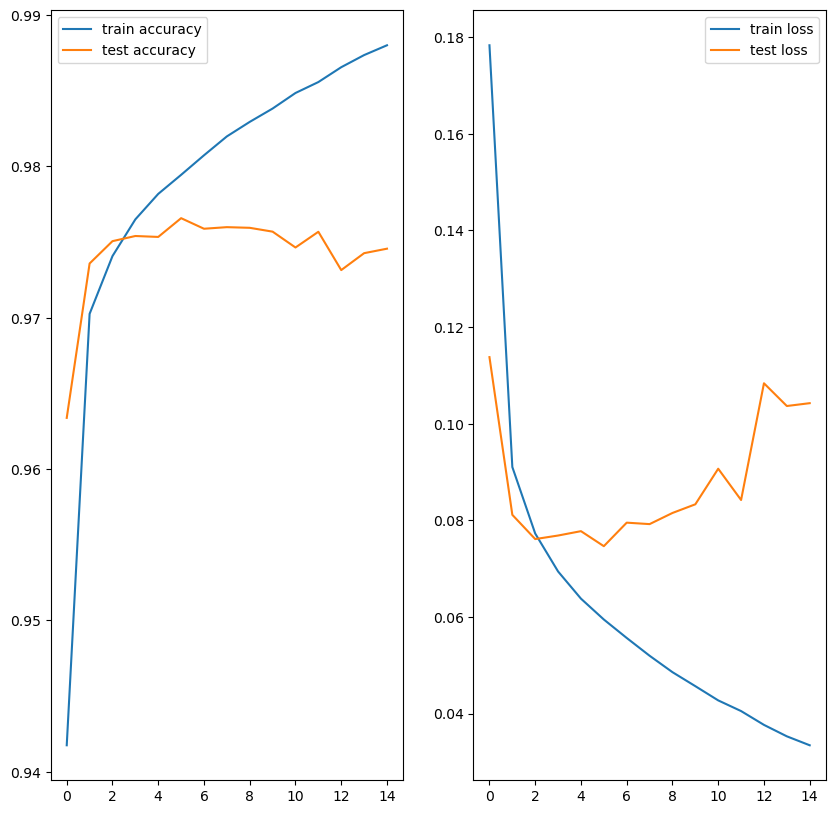

In [ ]:
#creating a model and run it for 15 epchs
myMod1 = BasicConv(tf.keras.optimizers.Adam())

print("Basic Convolutional Network, optimizer=Adam")
run(myMod1,config_name = f'BASIC1')

As we can see our model overfits after 6 epochs (the test data looses accuracy while the train data's accuracy is getting higher). Therefore we create a new model, but this time we only train it for 6 epochs.

Basic Convolutional Network, optimizer=Adam
Epoch 0: 


14320it [30:44,  7.76it/s]


train_loss: 0.19247190654277802
train_acc: 0.9369786977767944
test_loss: 0.10164173692464828
test_acc: 0.9668534994125366


Epoch 1: 


14320it [05:22, 44.35it/s]


train_loss: 0.09008228778839111
train_acc: 0.9707208275794983
test_loss: 0.0967518538236618
test_acc: 0.9699175953865051


Epoch 2: 


14320it [05:13, 45.67it/s]


train_loss: 0.07619874179363251
train_acc: 0.9744462370872498
test_loss: 0.07794757932424545
test_acc: 0.9750156998634338


Epoch 3: 


14320it [05:15, 45.43it/s]


train_loss: 0.06797102093696594
train_acc: 0.9770934581756592
test_loss: 0.08015824854373932
test_acc: 0.9738371968269348


Epoch 4: 


14320it [05:07, 46.59it/s]


train_loss: 0.0627455934882164
train_acc: 0.9785163998603821
test_loss: 0.0816095694899559
test_acc: 0.9736887812614441


Epoch 5: 


14320it [05:47, 41.18it/s]


train_loss: 0.05844523757696152
train_acc: 0.9799589514732361
test_loss: 0.07130081951618195
test_acc: 0.9772766828536987




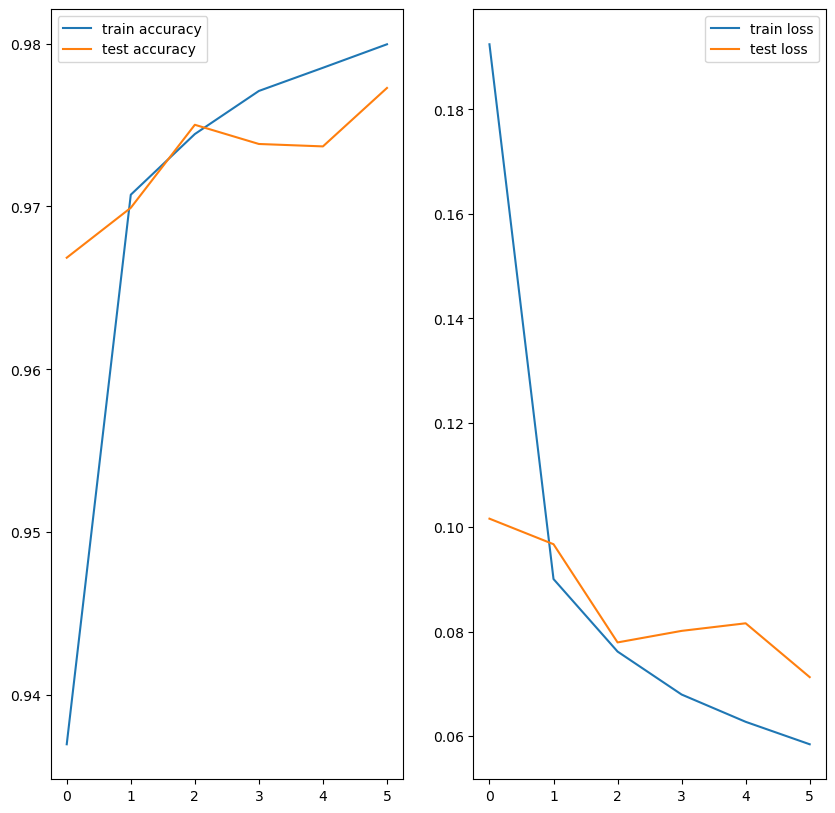

In [ ]:
#creating a model and running it for 6 epochs
myMod2 = BasicConv(tf.keras.optimizers.Adam())

print("Basic Convolutional Network, optimizer=Adam")
run(myMod2,6,config_name = f'BASIC2')

Now we stopped training just before the model would overfit again and also recieved a quite high train and test accuracy with more than 97%.
So now we can load it again (because the session expired) and see at some examples, how well it predicts the labels for the pictures.

In [ ]:
#load the second model again to use it again
myMod2_loaded = BasicConv(tf.keras.optimizers.Adam())
myMod2_loaded.load_weights(f"saved_model_{f'BASIC2'}")

In [ ]:
#get the predicted targets of the model for the pictures, we also showed at the beginning of the notebook
targets = []
for img in pictures:
    targets.append(myMod2_loaded(tf.expand_dims(((tf.cast(img, tf.float32)/128.)-1.),axis=0)))

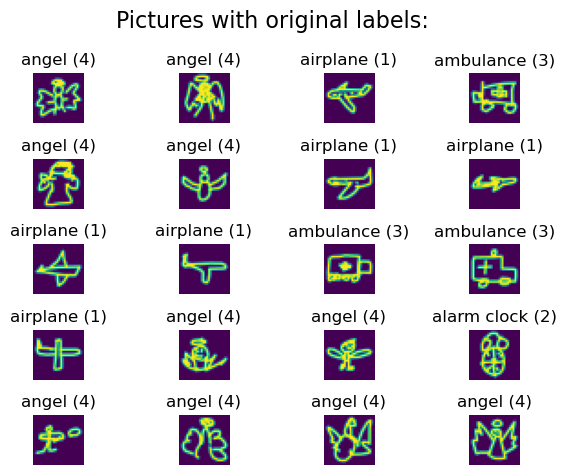

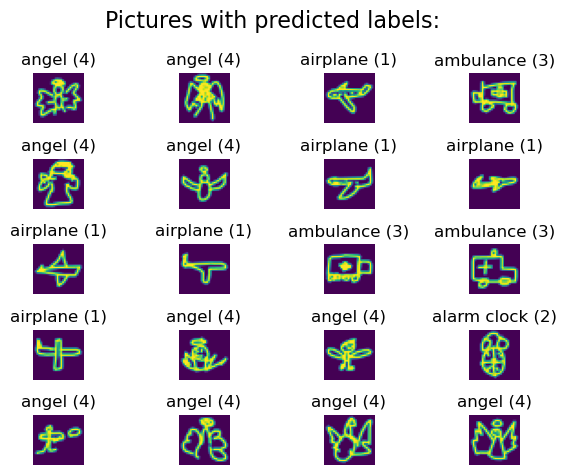

In [ ]:
#plot again the images with the original labels and also with the predicted labels
fig,axes = plt.subplots(nrows=5,ncols=4)
i=0
for row in range(5):
    for col in range(4):
        axes[row][col].imshow(pictures[i])
        axes[row][col].set_title(label_names[int(labels[i])] + " (" + str(int(labels[i])) + ")")
        axes[row][col].axis('off')
        i=i+1

fig.suptitle("Pictures with original labels: ",fontsize=16)
fig.tight_layout()


fig,axes = plt.subplots(nrows=5,ncols=4)
i=0
for row in range(5):
    for col in range(4):
        axes[row][col].imshow(pictures[i])
        axes[row][col].set_title(label_names[int(tf.argmax(targets[i],axis=1))+1] + " (" + str(int(tf.argmax(targets[i],axis=1))+1) + ")")
        axes[row][col].axis('off')
        i=i+1

fig.suptitle("Pictures with predicted labels: ",fontsize=16)
fig.tight_layout()

As you can see the model predicted those exemplary images correctly, so in the scenario of lucid dreaming, happily our dreamer's eye movement would have been understood correctly :)